<a href="https://colab.research.google.com/github/lizhieffe/nn_grad_engine/blob/main/Neural_Networks_Zero_to_Hero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This instruction implements the training procedure for ML.

- Instruction video: https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ
- The implementation is a simple version of Micrograd: https://github.com/karpathy/micrograd

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Nemerical calculation of derivative

## Uni-variable function

In [ ]:
# Just a random function
def f(x):
  return 3 * x**2 - 4 * x + 5

In [ ]:
f(3)

20

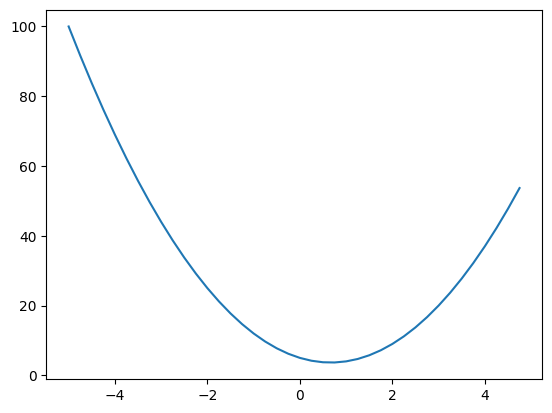

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

- In DL, the derivative is not solved in the analytical (symbolic) way, because the model is very complicated.

- Look at the definition of derivative:

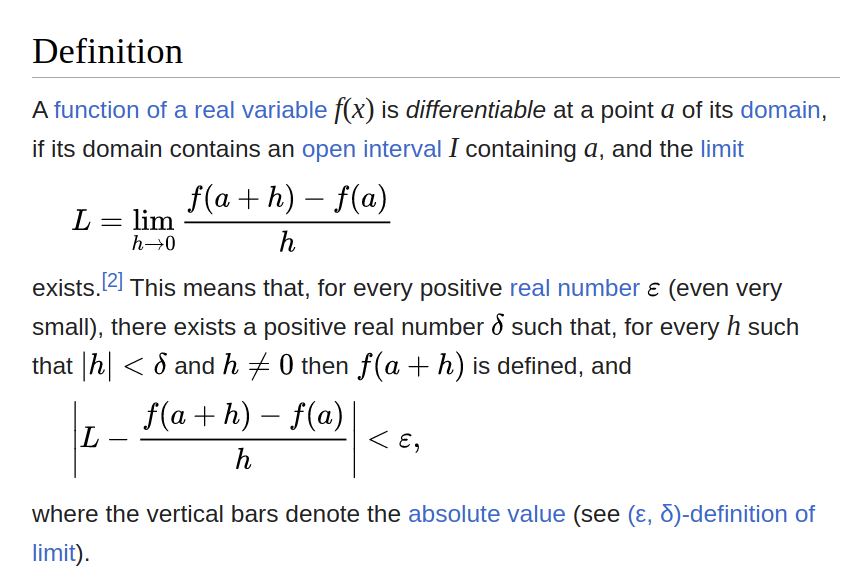

In [ ]:
# Numerical calculation of Derivative
def der(fn, val):
  h = 0.00000001
  f_a_plus_h = fn(val + h)
  f_a = fn(val)
  return (f_a_plus_h - f_a) / h

In [ ]:
der(f, 3)

14.00000009255109

In [ ]:
der(f, -3)

-22.00000039920269

In [ ]:
der(f, 2/3)

0.0

## Bi-variable function

- Slightly more complicated compared to uni-var function

In [ ]:
def g(a, b, c):
  return a * b + c

In [ ]:
g(2.0, -3.0, 10.0)

4.0

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = g(a, b, c)
a += h
d2 = g(a, b, c)
slope = (d2 - d1) / h

print(f'derivative to a = {slope}')

derivative to a = -3.000000000010772


# Neuron Network

## Necessary data structures

In [ ]:
class Value:

  # _children and _op are the values and operations generates the current value
  # They can be used to build a abstract-syntax tree (AST)
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data

    # This class may eventually represent the weight of NN. We are interested in
    # the gradiant of the final loss w.r.t to the weights.
    #
    # The class may also represent the data. We don't want to know the derivative
    # to the data because data is fixed.
    #
    # This field is the derivative of loss w.r.t. the value this class holds.
    #
    # Initially set to 0, meaning the change of the variable doesn't have effect
    # on the loss.
    self.grad = 0.0

    # Do the chain rule.
    # Store how to chain the output gradient to the input gradient.
    self._backward = lambda: None

    self._prev = set(_children)
    self._op = _op
    self.label = label

  # The __repr__() method returns a more information-rich, or official, string representation of an object.
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    # This is to support `Value + 1`
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # Because of chain rule - the add op doesn't change the backpropagated grad.
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  # "r"-add, to support Other + Value
  def __radd__(self, other):
    # Other + Value = Value + Other
    return self + other

  def __neg__(self):
    return self * (-1)

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    # This is to support `Value * 2`
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      # Because of chain rule - the mul op changes the backpropagated grad by a
      # factor of the multiplied data.
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward

    return out

  # Support Other * Value
  def __rmul__(self, other):
    # Other * Value = Value * Other
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  # Expect `other` to be a constant
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    # p = math.pow(self.data, other)
    p = self.data**other
    out = Value(p, (self,), label=f'**{other}')

    def _backward():
      self.grad += out.grad * other * math.pow(self.data, other-1)
    out._backward = _backward

    return out

  def tanh(self):
    ex = math.exp(self.data)
    emx = math.exp((-1.0) * self.data)
    out = Value((ex - emx) / (ex + emx), (self, ), label='tanh')

    def _backward():
      self.grad += out.grad * (1 - out.data**2)
    out._backward = _backward

    return out

  def exp(self):
    ex = math.exp(self.data)
    out = Value(ex, (self, ), label='exp')

    def _backward():
      self.grad += ex * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(node):
      visited.add(node)
      for child in node._prev:
        if child not in visited:
          build_topo(child)
      topo.append(node)

    build_topo(self)

    for node in reversed(topo):
      node._backward()

In [ ]:
Value(2.0)

Value(data=2.0)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
print(f'a + b = {a + b}')
print(f'a * b = {a * b}')

a + b = Value(data=-1.0)
a * b = Value(data=-6.0)


In [ ]:
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
print(f'a * b + c = {d}')

a * b + c = Value(data=4.0)


In [ ]:
f = Value(-2.0, label='f')

# Output of our graph. Meaning 'loss function'
#
# The derivative of loss w.r.t. itself is 1.0
L = f * d; L.label = 'L'; L.grad = 1.0

In [ ]:
# Visualize the AST
from graphviz import Digraph

def trace(root):
  # Build a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operations, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
f.grad = d.data
d.grad = f.data
c.grad = d.grad * 1
e.grad = f.data
a.grad = f.data * b.data
b.grad = f.data * a.data

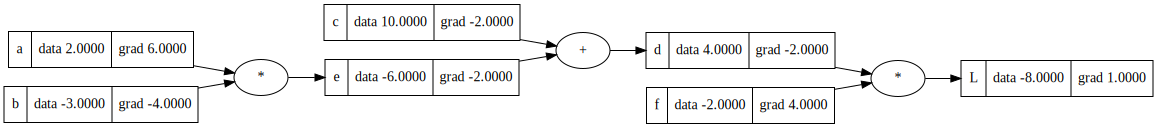

In [ ]:
draw_dot(L)

In [ ]:
# Create a function with the same variables as above, so that it doesn't pollute the global scope
def lol():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0+h, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print(f'derivative of d = {(L2 - L1) / h}')

In [ ]:
lol()

derivative of d = -4.000000000008441


# Try a real Neuron Network

## Activation function: tanh()

- Compared to sigmoid: both are S-shape. Major difference is that sigmoid is between [0, 1] and tanh is [-1, 1]

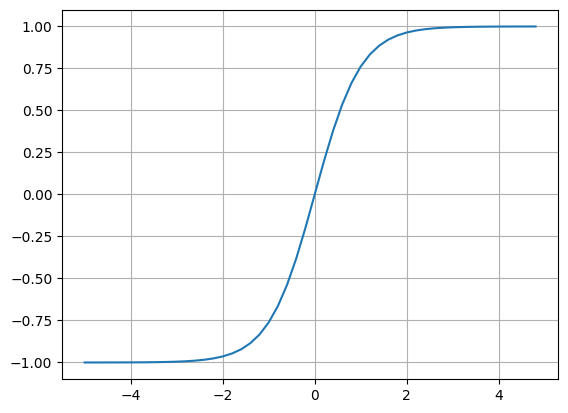

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

## Implement a simple neuron

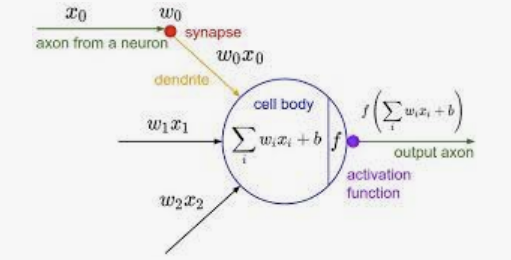

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# z
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------------
# o = n.tanh()

# Use a different expression for tanh to show case that all the ops are supported.
# The end results are the same
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -------------

o.label = 'o'

## [Option 1] Calculate the backpropagation by hand using calculus

In [ ]:
# Gradient on itself is always 1.0
o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = 1 - o.data**2

# n = x1w1x2w2 + b
# do/db = do/dn * dn/db = do/dn
b.grad = n.grad

# do/d(x1w1x2w2) = do/dn * dn/x1w1x2w2 = do/dn
x1w1x2w2.grad = n.grad

# x1w1x2w2 = x1w1 + x2w2
# do/d(x1w1) = do/d(x1w1x2w2) * d(x1w1x2w2)/d(x1w1) = do/dn
# do/d(x2w2) = do/d(x1w1x2w2) * d(x1w1x2w2)/d(x2w2) = do/dn
x1w1.grad = n.grad
x2w2.grad = n.grad

# x1w1 = x1*w1
# do/dw1 = do/d(x1w1) * d(x1w1)/dw1 = do/dn * x1
w1.grad = n.grad * x1.data
x1.grad = n.grad * w1.data
w2.grad = n.grad * x2.data
x2.grad = n.grad * w2.data


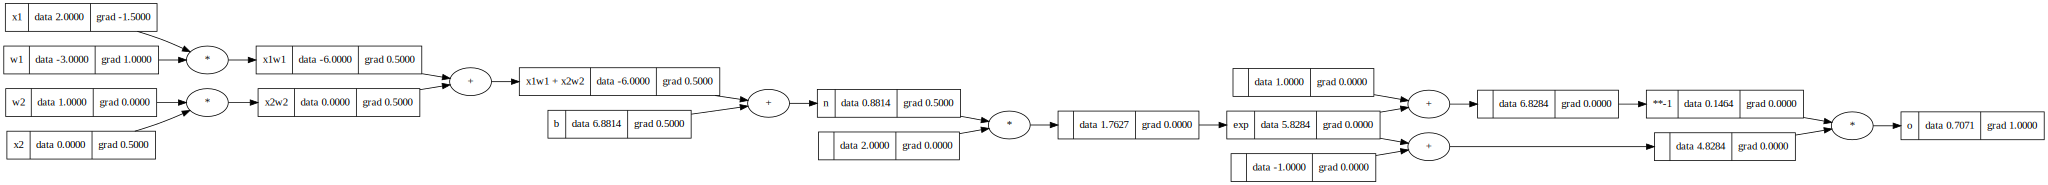

In [ ]:
draw_dot(o)

## [Option 2] Manually apply the chain rule to calculate the backpropagation

- Call the Value._backward() to backpropogate the grads
- Here we manually call the _backward() on each node from the end. In practice, the topology sort can be used to know the dependencies of nodes and to call them in sequence.

In [ ]:
# Gradient on itself is always 1.0
o.grad = 1.0

o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

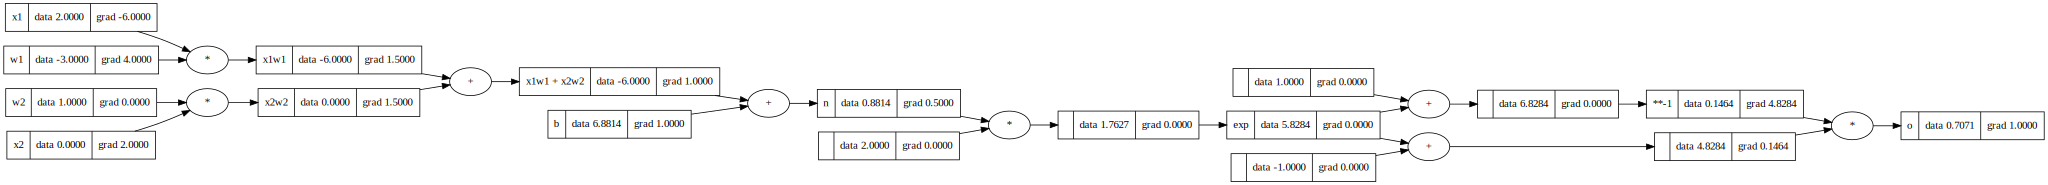

In [ ]:
draw_dot(o)

## [Option 3] Use the topological sort to backpropagate automatically.

In [ ]:
# Gradient on itself is always 1.0
o.grad = 1.0

o.backward()

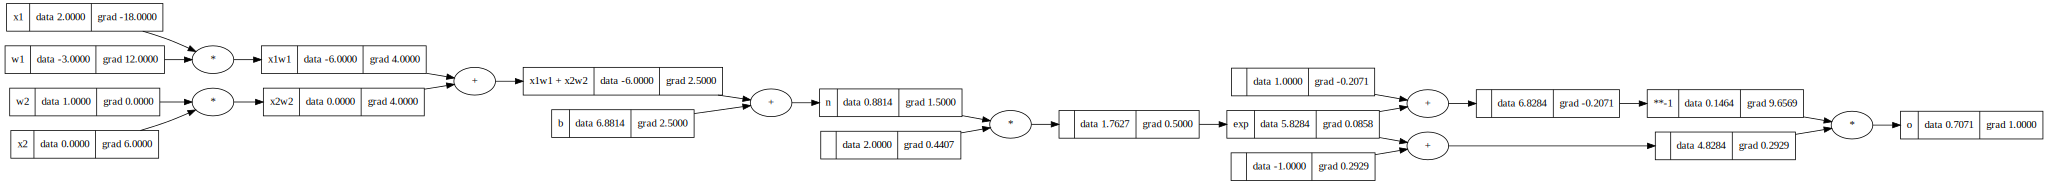

In [ ]:
draw_dot(o)

## Now use each node more than once to build a N-2-N connectivity

- We change the grad assignment in the Value() class from `self.grad = ...` to `self.grad += ...` because of the chain rule, so that when a node connects to multiple nodes in the next layer, its grad is not reset by each node in the next layer, and instead is accumulated.

In [ ]:
a = Value(3.0, label='a')
b = a+a; b.label ='b'
b.grad = 1.0
b.backward()

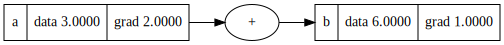

In [ ]:
draw_dot(b)

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label ='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.grad = 1.0
f.backward()

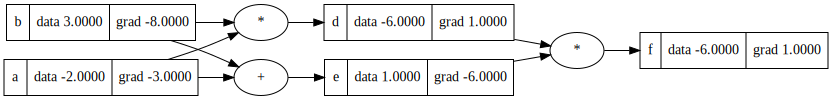

In [ ]:
draw_dot(f)

# Implement the tanh() in a different way

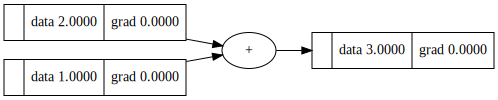

In [ ]:
a = Value(2.0)

draw_dot(1+a)

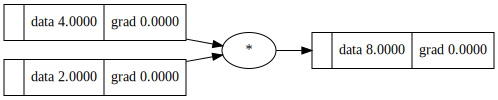

In [ ]:
draw_dot(a * 4)

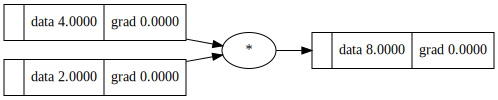

In [ ]:
draw_dot(4*a)

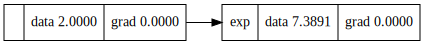

In [ ]:
draw_dot(a.exp())

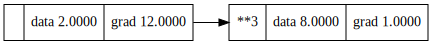

In [ ]:
b = Value(4.0)
_out = a**3
_out.grad = 1
_out.backward()
draw_dot(_out)

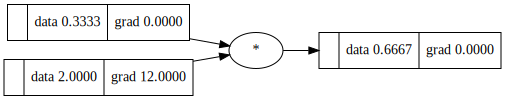

In [ ]:
draw_dot(a / 3.0)

# Use PyTorch API

The PyTorch uses very similar API as what we integrated. One major difference is that it supports tensor instead scalar.

See the example below.

In [ ]:
import torch

# Note that for Leaf nodes, the requires_grad = False, because they are input
# values (fixed) and no need to have gradient.
x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Build Neuron Network

## MLP

In [ ]:
import random

class Neuron:

  # nin: number of inputs
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  # w * x + b
  def __call__(self, x):
    assert len(x) == len(self.w)
    out = 0
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

In [ ]:
class Layer:
  # nin: number of neurons in the previous layer
  # nout: number of nuerons in this layer
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    out = []
    for n in self.neurons:
      out += n.parameters()
    return out

In [ ]:
class MLP:

  # nin: number of input values
  # nout: a list containing the output of hidden and final layers
  def __init__(self, nin, nouts):
    s = [nin] + nouts
    self.layers = [Layer(s[i], s[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    out = []
    for layer in self.layers:
      out += layer.parameters()
    return out

In [ ]:
n = Neuron(2)
n((2, 3))

Value(data=0.9953168345769225)

In [ ]:
x = [2, 3]
L = Layer(2, 3)
L(x)

[Value(data=0.4647937535818439),
 Value(data=0.9488625465387804),
 Value(data=-0.056915129327423715)]

In [ ]:
n = MLP(3, [4, 4, 1])
x = [2, 3, -1.0]
_t = n(x)

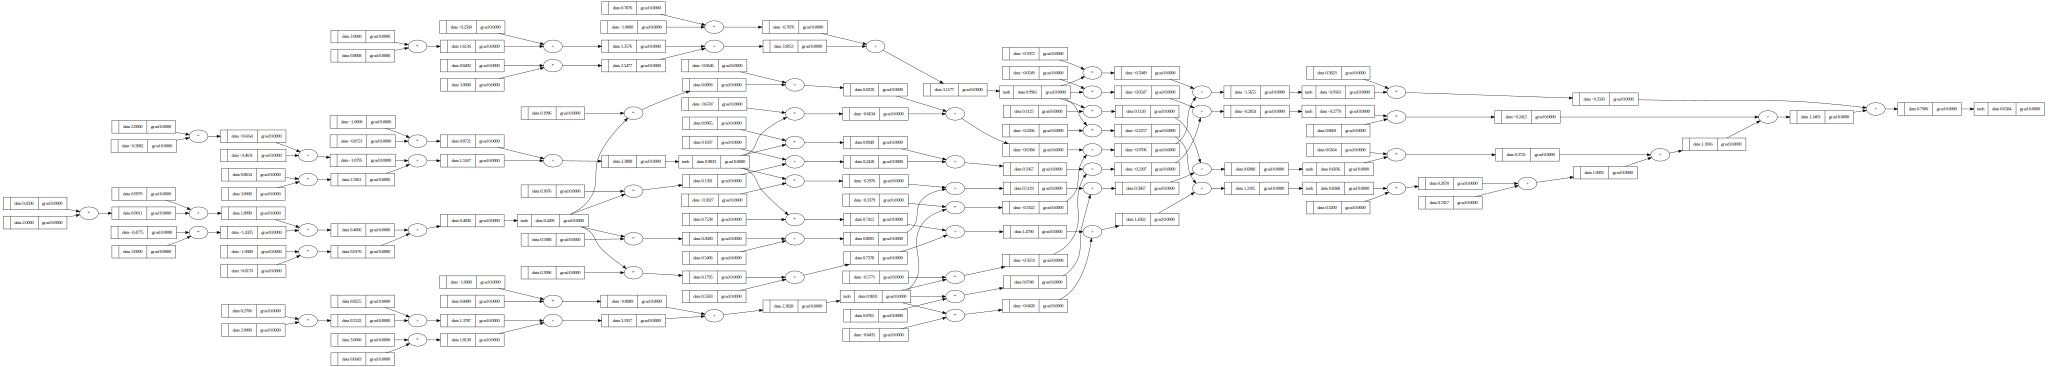

In [ ]:
draw_dot(_t)

## A classification problem example

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.6584327038558625), Value(data=0.7843967838607734), Value(data=0.6806441750933644), Value(data=0.8119917375617454)]


## Loss

In [ ]:
loss = sum((yp - y)**2 for yp, y in zip(ypred, ys))
loss

Value(data=6.160652050068195)

In [ ]:
loss.grad = 1.0
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].data

0.4505600968449395

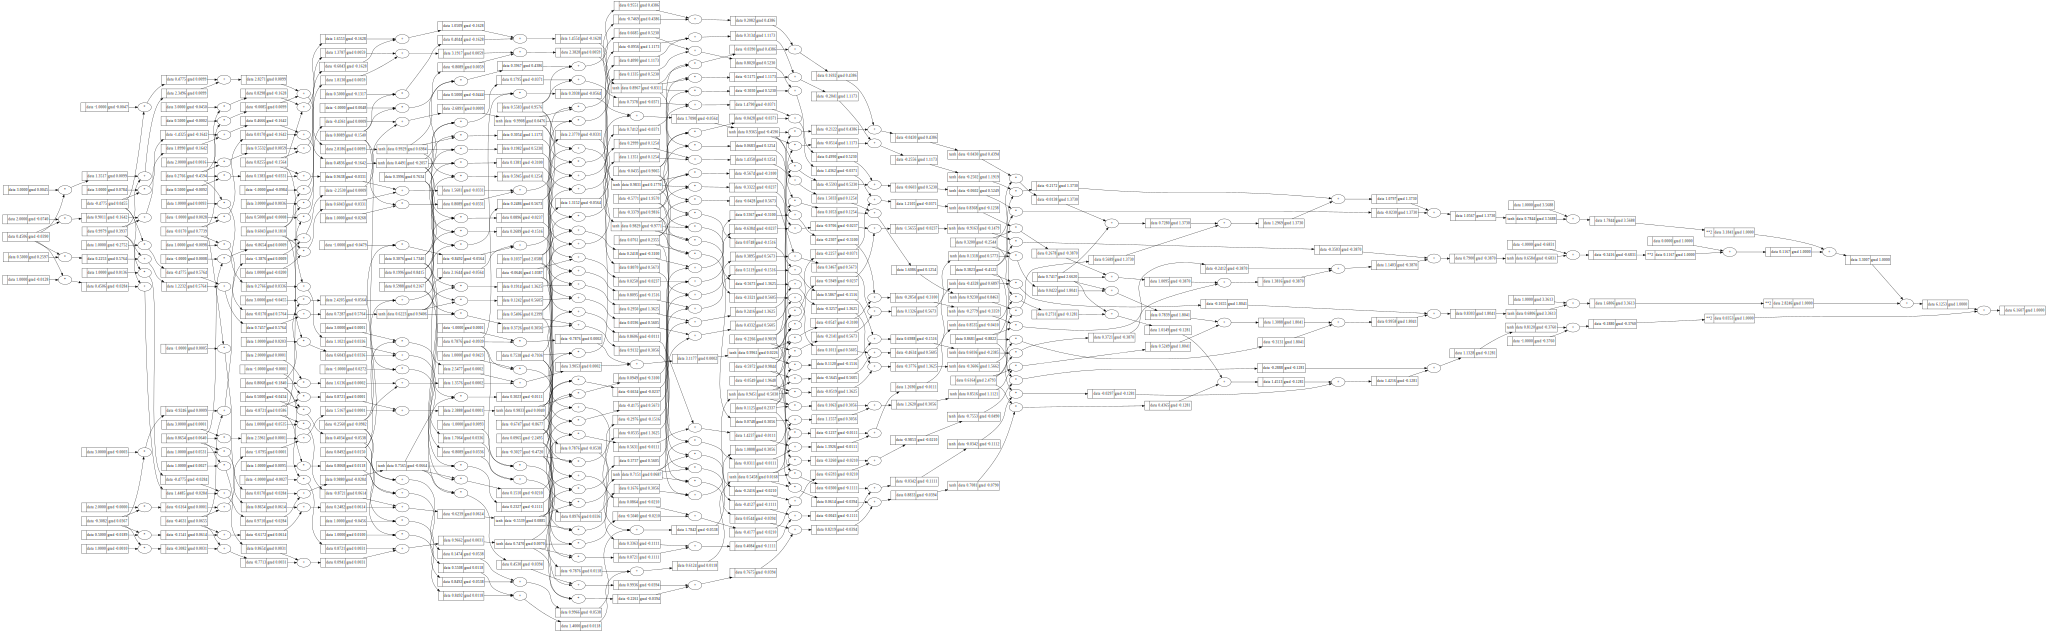

In [ ]:
draw_dot(loss)

## Training loop

In [ ]:
n = MLP(3, [4, 4, 1])


xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
print(ypred)

learning_rate = 0.01
print_every_n_steps = 500

for i in range(10000):

  # Forward pass
  ypred = [n(x) for x in xs]

  # calculate loss
  loss = sum((yp - y)**2 for yp, y in zip(ypred, ys))

  if i % print_every_n_steps == 0:
    print(f'i = {i}')
    for y, yp in zip(ys, ypred):
      print(f'y = {y}, pred = {yp.data}')
    print(f'loss = {loss.data}\n\n\n')

  # backward pass
  loss.grad = 1.0
  loss.backward()

  # update params
  for p in n.parameters():
    p.data -= learning_rate * p.grad
    # Reset the grad to avoid it accumulates across the iterations
    # !!! This is very easy to forget
    p.grad = 0


[Value(data=-0.9090023358601352), Value(data=-0.9115019935534721), Value(data=-0.8472389455441641), Value(data=-0.9651318543814964)]
i = 0
y = 1.0, pred = -0.9090023358601352
y = -1.0, pred = -0.9115019935534721
y = -1.0, pred = -0.8472389455441641
y = 1.0, pred = -0.9651318543814964
loss = 7.53720096032778



i = 500
y = 1.0, pred = 0.9622478961004148
y = -1.0, pred = -0.9813237436327341
y = -1.0, pred = -0.9545630521260028
y = 1.0, pred = 0.9519492429559457
loss = 0.006147415385351983



i = 1000
y = 1.0, pred = 0.9736904354735633
y = -1.0, pred = -0.9863547861484975
y = -1.0, pred = -0.9684351654739631
y = 1.0, pred = 0.967477899075007
loss = 0.002932410873855492



i = 1500
y = 1.0, pred = 0.9786186792972924
y = -1.0, pred = -0.9886110110802218
y = -1.0, pred = -0.9743868060749887
y = 1.0, pred = 0.9739910262473662
loss = 0.001919372362312291



i = 2000
y = 1.0, pred = 0.9815241750326854
y = -1.0, pred = -0.9899758877813628
y = -1.0, pred = -0.9778889705048601
y = 1.0, pred = 0.97